<a href="https://colab.research.google.com/github/hackathon-ficaAi/churnInsight/blob/data-science/jupyter_notebook/rascunho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 kB 3.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
# Bibliotecas para gerar gráficos
import matplotlib.pyplot as plt
import seaborn as sns
# Encode e preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from feature_engine import discretisation, encoding
# Modelos de classificação
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
# Métricas
from sklearn import metrics
# serialização
import joblib

In [4]:
# Colocando os dados traduzidos em um DataFrame
url = 'https://raw.githubusercontent.com/hackathon-ficaAi/churnInsight/refs/heads/main/data/treino.csv'
df = pd.read_csv(url)
df.head()

,id_cliente,idade,localizacao,tipo_assinatura,plano_pagamento,num_pausas_assinatura,metodo_pagamento,chamados_suporte,data_inscricao,horas_semanais,tempo_medio_sessao,taxa_skip_musica,musicas_tocadas_semana,musicas_unicas_semana,num_artistas_favoritos,num_amigos_plataforma,num_playlists_criadas,num_playlists_compartilhadas,notificacoes_clicadas,churned
0,1,60,Maine,familia premium,anual,0,credito,nenhum,6/22/2013,8.231109,0.880944,0.10,148,93,8,74,8,4,0,0
1,2,69,California,basico,mensal,1,credito,poucos,5/29/2018,13.109191,2.580870,0.60,158,80,4,54,12,3,54,0
2,3,36,Nebrasksa,premium,anual,1,debito,nenhum,12/9/2016,19.617798,0.935676,0.21,319,188,5,89,11,3,156,0
3,4,73,Montana,premium,mensal,0,debito,nenhum,8/30/2017,26.023783,0.878620,0.15,375,354,6,45,8,4,149,0
4,5,58,Virginia,familia premium,anual,0,credito,muito frequente,8/9/2013,17.876039,0.496145,0.01,239,124,8,69,12,6,0,0


In [5]:
# Juntando data de inscrição para inscrição Anual
df['data_inscricao'] = pd.to_datetime(df['data_inscricao'])
df['ano_inscricao'] = df['data_inscricao'].dt.to_period('A')
df['ano_inscricao'].value_counts().sort_index()

/tmp/ipython-input-740319196.py:3: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'Y' instead.
  df['ano_inscricao'] = df['data_inscricao'].dt.to_period('A')


,count
ano_inscricao,
2013,1405
2014,1357
2015,1310
2016,1376
2017,1374
2018,1422
2019,1380
2020,1356
2021,1347


In [6]:
# Criando uma série temporal - com os anos de 2022 e 2021
ultimo_ano = df['ano_inscricao'].max()
oot = df[df['ano_inscricao'] >= (ultimo_ano - 1)].copy()
oot

,id_cliente,idade,localizacao,tipo_assinatura,plano_pagamento,num_pausas_assinatura,metodo_pagamento,chamados_suporte,data_inscricao,horas_semanais,...,taxa_skip_musica,musicas_tocadas_semana,musicas_unicas_semana,num_artistas_favoritos,num_amigos_plataforma,num_playlists_criadas,num_playlists_compartilhadas,notificacoes_clicadas,churned,ano_inscricao
16,17,59,North Dakota,basico,mensal,1,credito,poucos,2021-08-18,4.060661,...,0.32,55,39,5,57,15,15,20,0,2021
21,22,51,Idaho,basico,anual,0,credito,alguns,2021-09-25,25.196482,...,0.87,427,398,6,57,6,2,17,0,2021
24,25,41,Vermont,familia premium,mensal,1,credito,poucos,2021-04-19,20.304050,...,0.86,340,216,5,71,11,3,2,0,2021
34,35,68,Alabama,basico,anual,1,debito,poucos,2022-01-01,0.912640,...,0.75,13,7,2,27,8,3,19,1,2022
38,39,28,Maine,estudante,anual,2,venmo,nenhum,2021-12-16,14.852901,...,0.40,202,185,6,83,7,2,20,0,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12460,12461,21,Idaho,estudante,anual,0,debito,muito frequente,2021-08-31,10.243765,...,0.04,181,155,5,97,7,7,40,0,2021
12467,12468,52,Alabama,premium,anual,1,debito,nenhum,2021-04-05,2.983817,...,0.67,52,48,5,58,11,6,23,0,2021
12475,12476,32,Alabama,premium,mensal,1,credito,nenhum,2021-07-30,29.752390,...,0.37,473,357,5,82,9,5,19,0,2021
12478,12479,79,New York,familia premium,anual,1,debito,muitos,2021-10-16,29.352786,...,0.46,526,407,9,28,10,10,0,0,2021


In [7]:
# Criando uma base de treino sem os anos de 2022 e 2021
df_train = df[df['ano_inscricao'] < (ultimo_ano - 1)].copy()
df_train

,id_cliente,idade,localizacao,tipo_assinatura,plano_pagamento,num_pausas_assinatura,metodo_pagamento,chamados_suporte,data_inscricao,horas_semanais,...,taxa_skip_musica,musicas_tocadas_semana,musicas_unicas_semana,num_artistas_favoritos,num_amigos_plataforma,num_playlists_criadas,num_playlists_compartilhadas,notificacoes_clicadas,churned,ano_inscricao
0,1,60,Maine,familia premium,anual,0,credito,nenhum,2013-06-22,8.231109,...,0.10,148,93,8,74,8,4,0,0,2013
1,2,69,California,basico,mensal,1,credito,poucos,2018-05-29,13.109191,...,0.60,158,80,4,54,12,3,54,0,2018
2,3,36,Nebrasksa,premium,anual,1,debito,nenhum,2016-12-09,19.617798,...,0.21,319,188,5,89,11,3,156,0,2016
3,4,73,Montana,premium,mensal,0,debito,nenhum,2017-08-30,26.023783,...,0.15,375,354,6,45,8,4,149,0,2017
4,5,58,Virginia,familia premium,anual,0,credito,muito frequente,2013-08-09,17.876039,...,0.01,239,124,8,69,12,6,0,0,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12494,12495,36,Virginia,familia premium,anual,2,credito,nenhum,2017-06-24,18.122941,...,0.16,246,124,6,88,9,9,2,0,2017
12496,12497,64,Wisconsin,familia premium,anual,1,debito,alguns,2020-11-06,17.397833,...,0.41,225,163,4,43,14,5,0,0,2020
12497,12498,21,California,basico,mensal,2,debito,nenhum,2019-08-05,16.543161,...,0.28,209,164,3,102,15,8,58,0,2019
12498,12499,70,New York,familia premium,anual,2,venmo,alguns,2015-06-26,1.691503,...,0.28,22,14,3,43,10,3,0,0,2015


In [8]:
# Separando target de features
target = 'churned'

categoricals = [
    'tipo_assinatura',
    'plano_pagamento',
    'metodo_pagamento',
    'chamados_suporte',
    'localizacao'
]

numericals = [
    col for col in df_train.columns
    if col not in categoricals + [target,
                                   'ano_inscricao','id_cliente']
]

X,y= df_train[categoricals + numericals], df_train[target]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    random_state=42,
                                                    test_size=0.2,
                                                    stratify=y)

In [10]:
# EXPLORE
def criar_features(df:pd.DataFrame):
    df = df.copy()
    # Cria uma coluna que indica se usuarios clicou em pelo menos uma notificação ou não
    df['clicou_notificacao'] = (df['notificacoes_clicadas'] > 0).astype(int)
    # Aplicando log para tratar inflação de zeros
    df['log_notificacoes'] = np.log1p(df['notificacoes_clicadas'])
    # Cria uma coluna com a relação de taxas de musicas unicas por semana
    df['taxa_musicas_unicas'] = df['musicas_unicas_semana']/df['musicas_tocadas_semana']
    # Fazendo uma coluna de "tempo de casa" para indicar quantos dias se passaram desde a inscrição do usuário
    data_referencia = df['data_inscricao'].max()
    df['data_inscricao'] = (data_referencia - df['data_inscricao']).dt.days
    return df

In [11]:
# Análise de comportamento por churn com variáveis numéricas
X_train.isna().sum().sort_values(ascending=False)

df_analise = X_train.copy()
df_analise = criar_features(df_analise)
feat_num = list(set(df_analise.columns) - set(categoricals))

df_analise[target] = y_train
sumario = df_analise[feat_num + [target]].groupby(by=target).agg(["mean","median"]).T

In [12]:
sumario['diff_abs'] = sumario[0] - sumario[1]
sumario['diff_rel'] = sumario[0]/sumario[1]
sumario.sort_values(by=['diff_rel'], ascending=False)

churned                                        0            1   diff_abs  \
taxa_skip_musica             median     0.330000     0.310000   0.020000   
                             mean       0.374382     0.353393   0.020989   
tempo_medio_sessao           mean       1.550831     1.492637   0.058194   
num_pausas_assinatura        mean       1.005069     0.968645   0.036424   
num_amigos_plataforma        median    64.000000    62.000000   2.000000   
musicas_unicas_semana        median   158.000000   156.000000   2.000000   
data_inscricao               mean    1459.646686  1442.511758  17.134928   
num_amigos_plataforma        mean      63.589659    63.161254   0.428405   
num_playlists_criadas        mean      11.845900    11.789474   0.056427   
clicou_notificacao           mean       0.866303     0.862262   0.004041   
log_notificacoes             mean       2.928075     2.920820   0.007255   
musicas_unicas_semana        mean     166.826765   166.493841   0.332924   
taxa_musicas_unicas          mean       0.690532     0.689546   0.000986   
idade                        mean      51.609555    51.597984   0.011571   
tempo_medio_sessao           median     1.272250     1.272181   0.000069   
num_artistas_favoritos       median     6.000000     6.000000   0.000000   
idade                        median    52.000000    52.000000   0.000000   
num_playlists_compartilhadas median     5.000000     5.000000   0.000000   
num_pausas_assinatura        median     1.000000     1.000000   0.000000   
clicou_notificacao           median     1.000000     1.000000   0.000000   
num_playlists_criadas        median    11.000000    11.000000   0.000000   
musicas_tocadas_semana       mean     240.478773   241.154535  -0.675762   
horas_semanais               mean      15.644084    15.723524  -0.079440   
log_notificacoes             median     3.891820     3.912023  -0.020203   
taxa_musicas_unicas          median     0.666667     0.670455  -0.003788   
num_artistas_favoritos       mean       5.591940     5.639418  -0.047478   
num_playlists_compartilhadas mean       6.246864     6.353863  -0.107000   
notificacoes_clicadas        median    48.000000    49.000000  -1.000000   
data_inscricao               median  1441.000000  1476.000000 -35.000000   
notificacoes_clicadas        mean      61.007604    62.547592  -1.539989   
musicas_tocadas_semana       median   236.000000   244.000000  -8.000000   
horas_semanais               median    15.766639    16.421962  -0.655324   

churned                              diff_rel  
taxa_skip_musica             median  1.064516  
                             mean    1.059393  
tempo_medio_sessao           mean    1.038988  
num_pausas_assinatura        mean    1.037603  
num_amigos_plataforma        median  1.032258  
musicas_unicas_semana        median  1.012821  
data_inscricao               mean    1.011879  
num_amigos_plataforma        mean    1.006783  
num_playlists_criadas        mean    1.004786  
clicou_notificacao           mean    1.004687  
log_notificacoes             mean    1.002484  
musicas_unicas_semana        mean    1.002000  
taxa_musicas_unicas          mean    1.001430  
idade                        mean    1.000224  
tempo_medio_sessao           median  1.000054  
num_artistas_favoritos       median  1.000000  
idade                        median  1.000000  
num_playlists_compartilhadas median  1.000000  
num_pausas_assinatura        median  1.000000  
clicou_notificacao           median  1.000000  
num_playlists_criadas        median  1.000000  
musicas_tocadas_semana       mean    0.997198  
horas_semanais               mean    0.994948  
log_notificacoes             median  0.994836  
taxa_musicas_unicas          median  0.994350  
num_artistas_favoritos       mean    0.991581  
num_playlists_compartilhadas mean    0.983160  
notificacoes_clicadas        median  0.979592  
data_inscricao               median  0.976287  
notificacoes_clicadas        mean    0.975379  
mus

In [13]:
X_train = criar_features(X_train)
arvore = tree.DecisionTreeClassifier(random_state=42)
arvore.fit(X_train[feat_num],y_train)

DecisionTreeClassifier(random_state=42)

[Text(0.8129164546384019, 0.9875, 'notificacoes_clicadas <= 404.5\ngini = 0.183\nsamples = 8784\nvalue = [7891, 893]\nclass = 0'),
 Text(0.8116154300815633, 0.9625, 'tempo_medio_sessao <= 3.719\ngini = 0.182\nsamples = 8782\nvalue = [7891.0, 891.0]\nclass = 0'),
 Text(0.8122659423599826, 0.9750000000000001, 'True  '),
 Text(0.648090085240375, 0.9375, 'tempo_medio_sessao <= 3.717\ngini = 0.186\nsamples = 8333\nvalue = [7470, 863]\nclass = 0'),
 Text(0.6467890606835366, 0.9125, 'taxa_skip_musica <= 0.485\ngini = 0.186\nsamples = 8332\nvalue = [7470, 862]\nclass = 0'),
 Text(0.5293874723540223, 0.8875, 'taxa_musicas_unicas <= 0.866\ngini = 0.194\nsamples = 6092\nvalue = [5429, 663]\nclass = 0'),
 Text(0.3593754615603782, 0.8625, 'taxa_musicas_unicas <= 0.866\ngini = 0.201\nsamples = 5163\nvalue = [4577, 586]\nclass = 0'),
 Text(0.3580744370035397, 0.8375, 'data_inscricao <= 2475.0\ngini = 0.201\nsamples = 5161\nvalue = [4577, 584]\nclass = 0'),
 Text(0.15451283562685497, 0.8125, 'taxa_mus

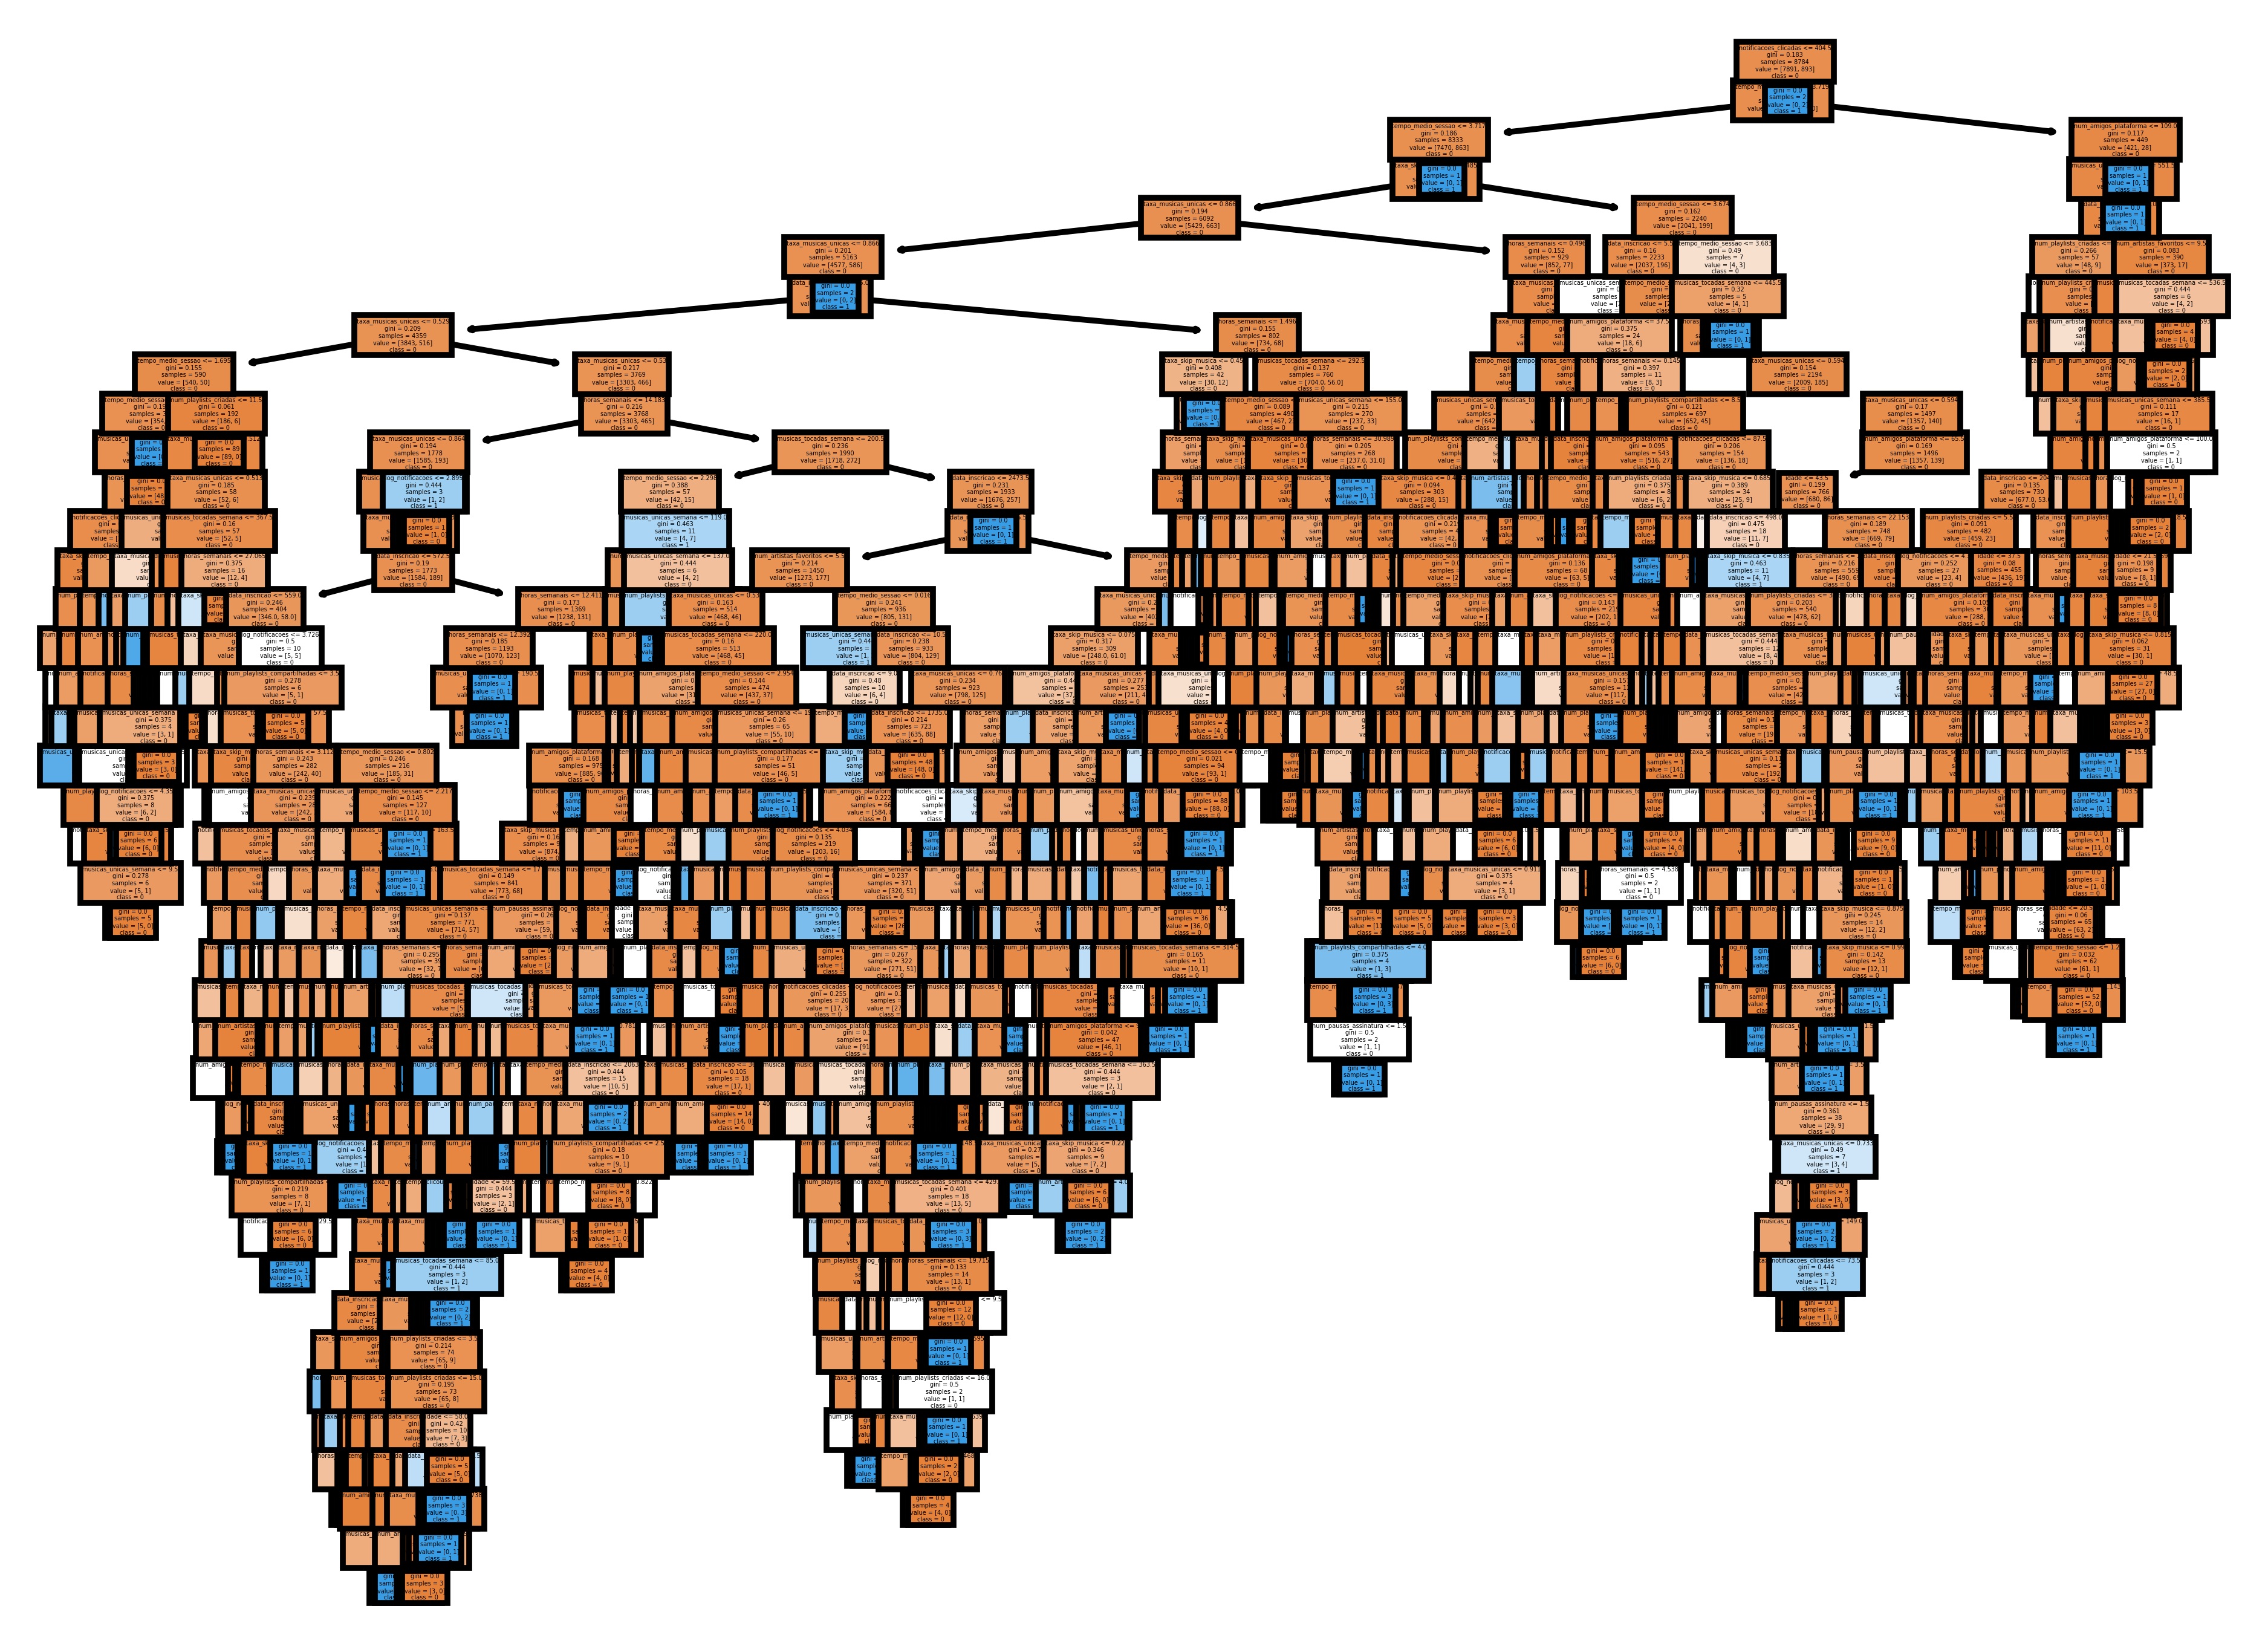

In [14]:
plt.figure(dpi=700)
tree.plot_tree(arvore,
               feature_names=X_train[feat_num].columns,
               filled=True,
               class_names=[str(i) for i in arvore.classes_])

In [15]:
# Nível de importância de cada feature avaliada pela árvore de decisão - Variáveis numéricas
feat_import_num = (pd.Series(arvore.feature_importances_,
                                    index=X_train[feat_num].columns)
                                    .sort_values(ascending=False)
                                    .reset_index()
                                    )

feat_import_num['acumulada'] = feat_import_num[0].cumsum()
feat_import_num

,index,0,acumulada
0,taxa_musicas_unicas,0.120664,0.120664
1,tempo_medio_sessao,0.111351,0.232014
2,horas_semanais,0.105270,0.337284
3,data_inscricao,0.091871,0.429156
4,taxa_skip_musica,0.085897,0.515052
5,num_amigos_plataforma,0.081657,0.596710
6,musicas_unicas_semana,0.068727,0.665437
7,musicas_tocadas_semana,0.066891,0.732328
8,idade,0.053620,0.785948
9,num_playlists_compartilhadas,0.046124,0.832072


In [16]:
# Análise de comportamento por churn com variáveis categóricas
df_analise = X_train[['tipo_assinatura','plano_pagamento','metodo_pagamento','chamados_suporte']].copy()
df_analise[target] = y_train

# Função que cria tabeças cruzadas por variável categórica
def resumo_categorica(var,df=df_analise, target=target):
    tabela = pd.crosstab(df[var], df[target], normalize='columns')

    resumo = tabela.copy()

    resumo['diff_abs'] = resumo[0] - resumo[1]
    resumo['diff_rel'] = resumo[0] / resumo[1]

    return resumo

In [17]:
resumo_categorica('tipo_assinatura')

churned,0,1,diff_abs,diff_rel
tipo_assinatura,,,,
basico,0.276011,0.283315,-0.007304,0.974219
estudante,0.099861,0.103024,-0.003163,0.969299
familia premium,0.393233,0.396417,-0.003184,0.991969
premium,0.230896,0.217245,0.013651,1.062836


In [18]:
resumo_categorica('plano_pagamento')

churned,0,1,diff_abs,diff_rel
plano_pagamento,,,,
anual,0.717019,0.68645,0.030569,1.044532
mensal,0.282981,0.31355,-0.030569,0.902506


In [19]:
resumo_categorica('metodo_pagamento')

churned,0,1,diff_abs,diff_rel
metodo_pagamento,,,,
credito,0.507920,0.516237,-0.008317,0.983889
debito,0.282474,0.292273,-0.009800,0.966471
venmo,0.209606,0.191489,0.018117,1.094608


In [20]:
resumo_categorica('chamados_suporte')

churned,0,1,diff_abs,diff_rel
chamados_suporte,,,,
alguns,0.199214,0.195969,0.003246,1.016562
muito frequente,0.201622,0.206047,-0.004425,0.978525
muitos,0.204283,0.185890,0.018393,1.098946
nenhum,0.200228,0.200448,-0.000220,0.998903
poucos,0.194652,0.211646,-0.016994,0.919706


In [21]:
from scipy.stats import chi2_contingency

def resumo_categorica_global(var, df=df_analise, target=target):
    # Crosstab absoluta (para chi²)
    tabela_abs = pd.crosstab(df[var], df[target])

    # Crosstab relativa (para diff)
    tabela_rel = pd.crosstab(df[var], df[target], normalize='columns')

    diff_abs = (tabela_rel[0] - tabela_rel[1]).abs().max()
    diff_rel = (tabela_rel[0] / tabela_rel[1]).apply(lambda x: max(x, 1/x)).max()

    chi2, p, _, _ = chi2_contingency(tabela_abs)

    return pd.Series({
        'max_diff_abs': diff_abs,
        'max_diff_rel': diff_rel,
        'chi2': chi2,
        'p_value': p
    })


In [22]:
resumo_final = (
    pd.DataFrame(
        {var: resumo_categorica_global(var) for var in df_analise.columns[:-1]}
    )
    .T
    .sort_values('chi2', ascending=False)
)

resumo_final

,max_diff_abs,max_diff_rel,chi2,p_value
plano_pagamento,0.030569,1.108026,3.522270,0.060549
chamados_suporte,0.018393,1.098946,2.640947,0.619587
metodo_pagamento,0.018117,1.094608,1.648109,0.438650
tipo_assinatura,0.013651,1.062836,0.906744,0.823800


In [23]:
df_analise_ohe = pd.get_dummies(df_analise[df_analise.columns[:-1]], drop_first=True)

arvore_cat = tree.DecisionTreeClassifier(
    random_state=42,
    max_depth=5,
    min_samples_leaf=50
)

arvore_cat.fit(df_analise_ohe, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=50, random_state=42)

In [24]:
feat_import_cat = (
    pd.Series(arvore_cat.feature_importances_, index=df_analise_ohe.columns)
    .sort_values(ascending=False)
)

feat_import_cat.head(15)

,0
chamados_suporte_nenhum,0.236130
metodo_pagamento_venmo,0.225729
tipo_assinatura_familia premium,0.167685
chamados_suporte_muitos,0.091855
tipo_assinatura_premium,0.083203
plano_pagamento_mensal,0.081799
chamados_suporte_muito frequente,0.075031
metodo_pagamento_debito,0.030695
tipo_assinatura_estudante,0.007875
chamados_suporte_poucos,0.000000


In [25]:
feat_import_cat_grouped = (
    feat_import_cat
    .groupby(lambda x: x.rsplit('_',1)[0])
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

feat_import_cat_grouped['acumulada'] = feat_import_cat_grouped[0].cumsum()
feat_import_cat_grouped

,index,0,acumulada
0,chamados_suporte,0.403015,0.403015
1,tipo_assinatura,0.258763,0.661778
2,metodo_pagamento,0.256424,0.918201
3,plano_pagamento,0.081799,1.000000


In [26]:
#best_features = (feat_import_num[feat_import_num['acumulada'] < 0.99]['index'].tolist()
#                + feat_import_cat_grouped[feat_import_cat_grouped['acumulada'] < 0.99]['index'].tolist())
best_features = feat_import_num[feat_import_num['acumulada'] < 0.99]['index'].tolist()

In [27]:
best_features

['taxa_musicas_unicas',
 'tempo_medio_sessao',
 'horas_semanais',
 'data_inscricao',
 'taxa_skip_musica',
 'num_amigos_plataforma',
 'musicas_unicas_semana',
 'musicas_tocadas_semana',
 'idade',
 'num_playlists_compartilhadas',
 'log_notificacoes',
 'num_playlists_criadas',
 'notificacoes_clicadas',
 'num_artistas_favoritos']

In [28]:
# MODIFY
# Discretização
tree_discretization = discretisation.DecisionTreeDiscretiser(variables=best_features,
                                                             regression=False,
                                                             bin_output="bin_number",
                                                             cv=3
                                                             )

# OneHot

onehot = encoding.OneHotEncoder(variables=best_features, ignore_format=True)

In [29]:
# MODEL
# Modelos -- Regressão Logistica
reg = linear_model.LogisticRegression(penalty=None,
                                      random_state=42
                                      )

In [30]:
# Modelos -- Random Forest
rf = RandomForestClassifier(random_state=42,
                            min_samples_leaf=20,
                            n_jobs=2,
                            n_estimators=10000)

In [31]:
# Criando pipeline
model_pipeline = Pipeline(
    steps=[
        ('Discretizar',tree_discretization),
        ('OneHot',onehot),
        ('Model',reg)
    ])

model_pipeline.fit(X_train[best_features],y_train)

Pipeline(steps=[('Discretizar',
                 DecisionTreeDiscretiser(bin_output='bin_number',
                                         regression=False,
                                         variables=['taxa_musicas_unicas',
                                                    'tempo_medio_sessao',
                                                    'horas_semanais',
                                                    'data_inscricao',
                                                    'taxa_skip_musica',
                                                    'num_amigos_plataforma',
                                                    'musicas_unicas_semana',
                                                    'musicas_tocadas_semana',
                                                    'idade',
                                                    'num_playlists_compartilhadas',
                                                    'log_notificacoes',
                                                    'num_playlists_c...
                               variables=['taxa_musicas_unicas',
                                          'tempo_medio_sessao',
                                          'horas_semanais', 'data_inscricao',
                                          'taxa_skip_musica',
                                          'num_amigos_plataforma',
                                          'musicas_unicas_semana',
                                          'musicas_tocadas_semana', 'idade',
                                          'num_playlists_compartilhadas',
                                          'log_notificacoes',
                                          'num_playlists_criadas',
                                          'notificacoes_clicadas',
                                          'num_artistas_favoritos'])),
                ('Model', LogisticRegression(penalty=None, random_state=42))])

In [32]:
y_train_predict = model_pipeline.predict(X_train[best_features])
y_train_proba = model_pipeline.predict_proba(X_train[best_features])[:,1]

acc_train = metrics.accuracy_score(y_train,y_train_predict)
auc_train = metrics.roc_auc_score(y_train, y_train_proba)
roc_train = metrics.roc_curve(y_train, y_train_proba)
print("Acurácia Treino:", acc_train)
print("AUC Treino:", auc_train)
print(f"Predições positivas treino: {y_train_predict.sum()} de {len(y_train)} ({y_train_predict.mean():.2%})")
print(f"Taxa real churn treino: {y_train.mean():.2%}")

Acurácia Treino: 0.8985655737704918
AUC Treino: 0.5701398662033363
Predições positivas treino: 2 de 8784 (0.02%)
Taxa real churn treino: 10.17%


In [33]:
X_test = criar_features(X_test)

y_test_predict = model_pipeline.predict(X_test[best_features])
y_test_proba = model_pipeline.predict_proba(X_test[best_features])[:,1]

acc_test = metrics.accuracy_score(y_test,y_test_predict)
auc_test = metrics.roc_auc_score(y_test, y_test_proba)
roc_test = metrics.roc_curve(y_test, y_test_proba)
print("Acurácia Teste:", acc_test)
print("AUC Teste:", auc_test)
print(f"Predições positivas teste: {y_test_predict.sum()} de {len(y_test)} ({y_test_predict.mean():.2%})")
print(f"Taxa real churn teste: {y_test.mean():.2%}")


Acurácia Teste: 0.8979963570127505
AUC Teste: 0.4610947340668532
Predições positivas teste: 1 de 2196 (0.05%)
Taxa real churn teste: 10.15%


In [34]:
oot = criar_features(oot)

oot_predict = model_pipeline.predict(oot[best_features])
oot_proba = model_pipeline.predict_proba(oot[best_features])[:,1]

acc_oot = metrics.accuracy_score(oot[target],oot_predict)
auc_oot = metrics.roc_auc_score(oot[target], oot_proba)
roc_oot = metrics.roc_curve(oot[target], oot_proba)
print("Acurácia oot:", acc_oot)
print("AUC oot:", auc_oot)
print(f"Predições positivas teste: {oot_predict.sum()} de {len(y_test)} ({oot_predict.mean():.2%})")
print(f"Taxa real churn teste: {y_test.mean():.2%}")

Acurácia oot: 0.9098684210526315
AUC oot: 0.49442658770999254
Predições positivas teste: 0 de 2196 (0.00%)
Taxa real churn teste: 10.15%


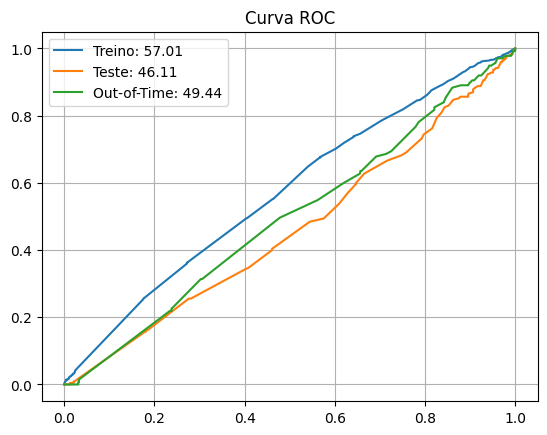

In [35]:
plt.plot(roc_train[0], roc_train[1])
plt.plot(roc_test[0], roc_test[1])
plt.plot(roc_oot[0], roc_oot[1])
plt.grid(True)
plt.title("Curva ROC")
plt.legend([
    f"Treino: {100*auc_train:.2f}",
    f"Teste: {100*auc_test:.2f}",
    f"Out-of-Time: {100*auc_oot:.2f}"
])

In [36]:
model_pipeline = Pipeline(
    steps=[
        ('Discretizar',tree_discretization),
        ('OneHot',onehot),
        ('Model',rf)
    ])

model_pipeline.fit(X_train[best_features],y_train)

Pipeline(steps=[('Discretizar',
                 DecisionTreeDiscretiser(bin_output='bin_number',
                                         regression=False,
                                         variables=['taxa_musicas_unicas',
                                                    'tempo_medio_sessao',
                                                    'horas_semanais',
                                                    'data_inscricao',
                                                    'taxa_skip_musica',
                                                    'num_amigos_plataforma',
                                                    'musicas_unicas_semana',
                                                    'musicas_tocadas_semana',
                                                    'idade',
                                                    'num_playlists_compartilhadas',
                                                    'log_notificacoes',
                                                    'num_playlists_c...
                                          'horas_semanais', 'data_inscricao',
                                          'taxa_skip_musica',
                                          'num_amigos_plataforma',
                                          'musicas_unicas_semana',
                                          'musicas_tocadas_semana', 'idade',
                                          'num_playlists_compartilhadas',
                                          'log_notificacoes',
                                          'num_playlists_criadas',
                                          'notificacoes_clicadas',
                                          'num_artistas_favoritos'])),
                ('Model',
                 RandomForestClassifier(min_samples_leaf=20, n_estimators=10000,
                                        n_jobs=2, random_state=42))])

In [37]:
y_train_predict = model_pipeline.predict(X_train[best_features])
y_train_proba = model_pipeline.predict_proba(X_train[best_features])[:,1]

acc_train = metrics.accuracy_score(y_train,y_train_predict)
auc_train = metrics.roc_auc_score(y_train, y_train_proba)
roc_train = metrics.roc_curve(y_train, y_train_proba)
print("Acurácia Treino:", acc_train)
print("AUC Treino:", auc_train)
print(f"Predições positivas treino: {y_train_predict.sum()} de {len(y_train)} ({y_train_predict.mean():.2%})")
print(f"Taxa real churn treino: {y_train.mean():.2%}")

Acurácia Treino: 0.8983378870673953
AUC Treino: 0.5837045137535313
Predições positivas treino: 0 de 8784 (0.00%)
Taxa real churn treino: 10.17%


In [38]:
#X_test = criar_features(X_test)

y_test_predict = model_pipeline.predict(X_test[best_features])
y_test_proba = model_pipeline.predict_proba(X_test[best_features])[:,1]

acc_test = metrics.accuracy_score(y_test,y_test_predict)
auc_test = metrics.roc_auc_score(y_test, y_test_proba)
roc_test = metrics.roc_curve(y_test, y_test_proba)
print("Acurácia Teste:", acc_test)
print("AUC Teste:", auc_test)
print(f"Predições positivas teste: {y_test_predict.sum()} de {len(y_test)} ({y_test_predict.mean():.2%})")
print(f"Taxa real churn teste: {y_test.mean():.2%}")

Acurácia Teste: 0.8984517304189436
AUC Teste: 0.4686848690505682
Predições positivas teste: 0 de 2196 (0.00%)
Taxa real churn teste: 10.15%


In [39]:
#oot = criar_features(oot)

oot_predict = model_pipeline.predict(oot[best_features])
oot_proba = model_pipeline.predict_proba(oot[best_features])[:,1]

acc_oot = metrics.accuracy_score(oot[target],oot_predict)
auc_oot = metrics.roc_auc_score(oot[target], oot_proba)
roc_oot = metrics.roc_curve(oot[target], oot_proba)
print("Acurácia oot:", acc_oot)
print("AUC oot:", auc_oot)
print(f"Predições positivas teste: {oot_predict.sum()} de {len(y_test)} ({oot_predict.mean():.2%})")
print(f"Taxa real churn teste: {y_test.mean():.2%}")

Acurácia oot: 0.9098684210526315
AUC oot: 0.4867314786959482
Predições positivas teste: 0 de 2196 (0.00%)
Taxa real churn teste: 10.15%


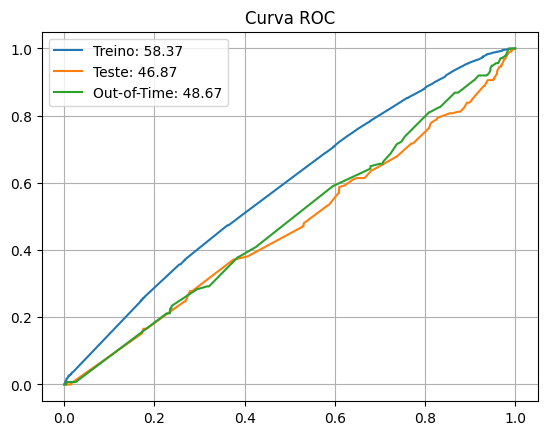

In [40]:
plt.plot(roc_train[0], roc_train[1])
plt.plot(roc_test[0], roc_test[1])
plt.plot(roc_oot[0], roc_oot[1])
plt.grid(True)
plt.title("Curva ROC")
plt.legend([
    f"Treino: {100*auc_train:.2f}",
    f"Teste: {100*auc_test:.2f}",
    f"Out-of-Time: {100*auc_oot:.2f}"
])